We are looking to predict and compute the frost point
============
Using the temperature and dewpoint

Therefore we will only aim to predict the temperature and dewpoint, to then compute the frost point

Using the following formula : 
## $T_f = T_d + \frac{2 671, 02}{\frac{2 954,61}{T} + 2,193665 \ln(T) - 13,3448} - T$

$T_f$ : the frost point temperature,
$T_d$ : the dewpoint temperature,
$T$ : the temperature.

In this notebook we are going to analyse the temperature.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import lightgbm as lgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

from statsmodels.tsa.statespace.sarimax import SARIMAX

## Implement the data and check it

In [2]:
data = pd.read_csv("climate_data.csv")
data.head()

,Date,Average temperature (°F),Average humidity (%),Average dewpoint (°F),Average barometer (in),Average windspeed (mph),Average gustspeed (mph),Average direction (°deg),Rainfall for month (in),Rainfall for year (in),...,Maximum humidity (%),Minimum humidity (%),Maximum pressure,Minimum pressure,Maximum windspeed (mph),Maximum gust speed (mph),Maximum heat index (°F),Date1,Month,diff_pressure
0,2009-01-01,37.8,35.0,12.7,29.7,26.4,36.8,274.0,0.0,0.0,...,4.0,27.0,29.762,29.596,41.4,59.0,40.0,2009-01-01,1,0.166
1,2009-01-02,43.2,32.0,14.7,29.5,12.8,18.0,240.0,0.0,0.0,...,4.0,16.0,29.669,29.268,35.7,51.0,52.0,2009-01-02,1,0.401
2,2009-01-03,25.7,60.0,12.7,29.7,8.3,12.2,290.0,0.0,0.0,...,8.0,35.0,30.232,29.260,25.3,38.0,41.0,2009-01-03,1,0.972
3,2009-01-04,9.3,67.0,0.1,30.4,2.9,4.5,47.0,0.0,0.0,...,7.0,35.0,30.566,30.227,12.7,20.0,32.0,2009-01-04,1,0.339
4,2009-01-05,23.5,30.0,-5.3,29.9,16.7,23.1,265.0,0.0,0.0,...,5.0,13.0,30.233,29.568,38.0,53.0,32.0,2009-01-05,1,0.665


First of all we notice that we've got among the features 5 different categories : Temperature, Humidity and Pressure, Wind, Rain, Time series.
In the temperature category we have :
- 'Average temperature (°F)'
- 'Maximum temperature (°F)'
- 'Minimum temperature (°F)'
- 'Maximum heat index (°F)'
- 'Average dewpoint (°F)'

In the Humidity and Pressure category :
- 'Average humidity (%)'
- 'Maximum humidity (%)' 
- 'Average barometer (in)'
- 'Minimum humidity (%)'
- 'Maximum pressure'
- 'Minimum pressure'
- 'diff_pressure'

In the Wind category : 
- 'Average windspeed (mph)'
- 'Average gustspeed (mph)'
- 'Maximum windspeed (mph)'
- 'Maximum gust speed (mph)
- 'Average direction (°deg)'

In the Rain category : 
- 'Rainfall for month (in)'
- 'Rainfall for year (in)' 
- 'Maximum rain per minute'

In Time : 
- 'Date1'
- 'Month'

In [3]:
print("Dimensions :", data.shape)
print("\nTypes de variables :")
print(data.dtypes)

Dimensions : (3902, 23)

Types de variables :
Date                         object
Average temperature (°F)    float64
Average humidity (%)        float64
Average dewpoint (°F)       float64
Average barometer (in)      float64
Average windspeed (mph)     float64
Average gustspeed (mph)     float64
Average direction (°deg)    float64
Rainfall for month (in)     float64
Rainfall for year (in)      float64
Maximum rain per minute     float64
Maximum temperature (°F)    float64
Minimum temperature (°F)    float64
Maximum humidity (%)        float64
Minimum humidity (%)        float64
Maximum pressure            float64
Minimum pressure            float64
Maximum windspeed (mph)     float64
Maximum gust speed (mph)    float64
Maximum heat index (°F)     float64
Date1                        object
Month                         int64
diff_pressure               float64
dtype: object


In [4]:
data.isnull().sum()

Date                        0
Average temperature (°F)    0
Average humidity (%)        0
Average dewpoint (°F)       0
Average barometer (in)      0
Average windspeed (mph)     0
Average gustspeed (mph)     0
Average direction (°deg)    0
Rainfall for month (in)     0
Rainfall for year (in)      0
Maximum rain per minute     0
Maximum temperature (°F)    0
Minimum temperature (°F)    0
Maximum humidity (%)        0
Minimum humidity (%)        0
Maximum pressure            0
Minimum pressure            0
Maximum windspeed (mph)     0
Maximum gust speed (mph)    0
Maximum heat index (°F)     0
Date1                       0
Month                       0
diff_pressure               0
dtype: int64

As we can see there is no missing value and all features are numericals except the date but we can put it to a datetime format instead of 'object', it is going to make the reading of the x axis easier, since it is correctly formated

In [5]:
for col in data.select_dtypes(include='object').columns:
    data[col] = pd.to_datetime(data[col], errors='raise')
print(data.dtypes)

Date                        datetime64[ns]
Average temperature (°F)           float64
Average humidity (%)               float64
Average dewpoint (°F)              float64
Average barometer (in)             float64
Average windspeed (mph)            float64
Average gustspeed (mph)            float64
Average direction (°deg)           float64
Rainfall for month (in)            float64
Rainfall for year (in)             float64
Maximum rain per minute            float64
Maximum temperature (°F)           float64
Minimum temperature (°F)           float64
Maximum humidity (%)               float64
Minimum humidity (%)               float64
Maximum pressure                   float64
Minimum pressure                   float64
Maximum windspeed (mph)            float64
Maximum gust speed (mph)           float64
Maximum heat index (°F)            float64
Date1                       datetime64[ns]
Month                                int64
diff_pressure                      float64
dtype: obje

We also see the value "Date1" but it's maybe the same as "Date" so we need to chack that and drop it if it was because that make it a usefull features

In [6]:
identical = (data["Date"] == data["Date1"]).all()

if identical:
    print("Columns have the same values ​​for all rows.")
else:
    diff_count = (data["Date"] != data["Date1"]).sum()
    print(f"Columns are different on {diff_count} rows.")

Columns have the same values ​​for all rows.


In [7]:
data = data.drop(columns=['Date1'])
data.head()

,Date,Average temperature (°F),Average humidity (%),Average dewpoint (°F),Average barometer (in),Average windspeed (mph),Average gustspeed (mph),Average direction (°deg),Rainfall for month (in),Rainfall for year (in),...,Minimum temperature (°F),Maximum humidity (%),Minimum humidity (%),Maximum pressure,Minimum pressure,Maximum windspeed (mph),Maximum gust speed (mph),Maximum heat index (°F),Month,diff_pressure
0,2009-01-01,37.8,35.0,12.7,29.7,26.4,36.8,274.0,0.0,0.0,...,34.0,4.0,27.0,29.762,29.596,41.4,59.0,40.0,1,0.166
1,2009-01-02,43.2,32.0,14.7,29.5,12.8,18.0,240.0,0.0,0.0,...,37.0,4.0,16.0,29.669,29.268,35.7,51.0,52.0,1,0.401
2,2009-01-03,25.7,60.0,12.7,29.7,8.3,12.2,290.0,0.0,0.0,...,6.0,8.0,35.0,30.232,29.260,25.3,38.0,41.0,1,0.972
3,2009-01-04,9.3,67.0,0.1,30.4,2.9,4.5,47.0,0.0,0.0,...,-0.0,7.0,35.0,30.566,30.227,12.7,20.0,32.0,1,0.339
4,2009-01-05,23.5,30.0,-5.3,29.9,16.7,23.1,265.0,0.0,0.0,...,15.0,5.0,13.0,30.233,29.568,38.0,53.0,32.0,1,0.665


Now we can use the date time to give information about where we are in the years and the fluctuation because of seasons and after that set directly the 'Data' as the index to make the dataset easier to use in all the future process

In [8]:
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day
data['Dayofyear'] = data['Date'].dt.dayofyear
data['Weekday'] = data['Date'].dt.weekday
data = data.set_index('Date')

In [9]:
data.head()

,Average temperature (°F),Average humidity (%),Average dewpoint (°F),Average barometer (in),Average windspeed (mph),Average gustspeed (mph),Average direction (°deg),Rainfall for month (in),Rainfall for year (in),Maximum rain per minute,...,Minimum pressure,Maximum windspeed (mph),Maximum gust speed (mph),Maximum heat index (°F),Month,diff_pressure,Year,Day,Dayofyear,Weekday
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,37.8,35.0,12.7,29.7,26.4,36.8,274.0,0.0,0.0,0.0,...,29.596,41.4,59.0,40.0,1,0.166,2009,1,1,3
2009-01-02,43.2,32.0,14.7,29.5,12.8,18.0,240.0,0.0,0.0,0.0,...,29.268,35.7,51.0,52.0,1,0.401,2009,2,2,4
2009-01-03,25.7,60.0,12.7,29.7,8.3,12.2,290.0,0.0,0.0,0.0,...,29.260,25.3,38.0,41.0,1,0.972,2009,3,3,5
2009-01-04,9.3,67.0,0.1,30.4,2.9,4.5,47.0,0.0,0.0,0.0,...,30.227,12.7,20.0,32.0,1,0.339,2009,4,4,6
2009-01-05,23.5,30.0,-5.3,29.9,16.7,23.1,265.0,0.0,0.0,0.0,...,29.568,38.0,53.0,32.0,1,0.665,2009,5,5,0


### Analyse and find features for the learning

In [10]:
print(data.describe().T.to_string())

                           count         mean         std       min       25%       50%        75%       max
Average temperature (°F)  3902.0    44.670733   15.326793   -12.100    33.700    45.100    58.0000    76.300
Average humidity (%)      3902.0    48.878011   17.438153     9.000    36.000    47.000    61.0000    94.000
Average dewpoint (°F)     3902.0    23.127037   14.634088   -22.200    12.100    22.500    35.4000    55.100
Average barometer (in)    3902.0    29.881420    0.250395    28.200    29.700    29.900    30.0000    31.000
Average windspeed (mph)   3902.0     5.758893    4.022485     0.000     2.700     4.600     8.0000    26.400
Average gustspeed (mph)   3902.0    10.011968   14.117446     0.000     4.500     7.100    12.1000   240.400
Average direction (°deg)  3902.0   216.037417   97.677761     0.000   116.000   253.000   282.0000   360.000
Rainfall for month (in)   3902.0     0.451105    0.603462     0.000     0.050     0.220     0.6700     4.480
Rainfall for year (

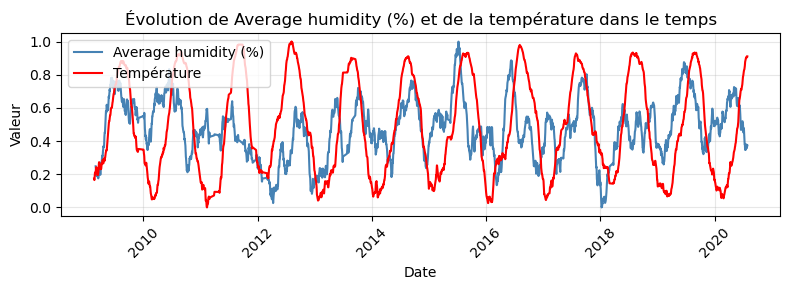

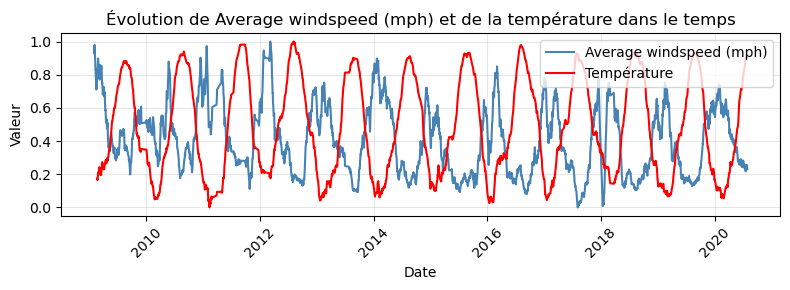

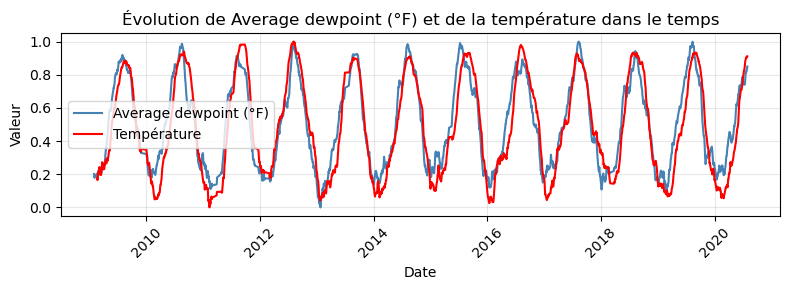

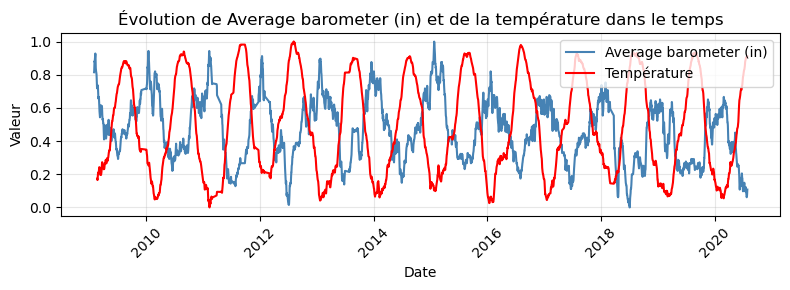

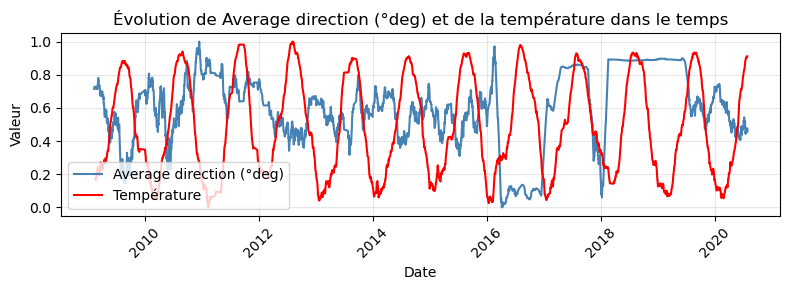

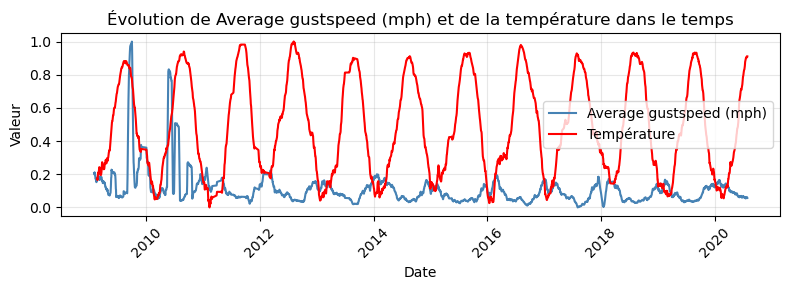

In [11]:
# Let's plot a few features to visualize their distributions and check for outliers
features_to_plot = {'Average humidity (%)': 60, 
                    'Average windspeed (mph)':30, 
                    'Average dewpoint (°F)':30, 
                    'Average barometer (in)':30, 
                    'Average direction (°deg)':40,
                    'Average gustspeed (mph)':30
}
target = 'Average temperature (°F)'
# Let's use rolling and mean to take out the noise
data_smooth = data.copy()
data_smooth[target] = data_smooth[target].rolling(50).mean()
for feature, win in features_to_plot.items():
    data_smooth[feature] = data_smooth[feature].rolling(window=win).mean()
# Now we are going to normalize it for a better readability
scaler = MinMaxScaler()
scaled_cols = [target] + list(features_to_plot.keys())
scaled_df = data_smooth.copy()
scaled_df[scaled_cols] = scaler.fit_transform(data_smooth[scaled_cols])
# As not all features have the same measurement units, we will create separate plots for each feature
# We use the Date feature as x-axis for time series plots
for feature in features_to_plot.keys():
    plt.figure(figsize=(8, 3))
    plt.title(f"Évolution de {feature} et de la température dans le temps")
    
    # Courbe du feature
    sns.lineplot(data = scaled_df,x="Date", y=feature, label=feature, color='steelblue')
    
    # Courbe de la température
    sns.lineplot(data = scaled_df,x="Date", y=target, label='Température', color='red')
    
    plt.xlabel("Date")
    plt.ylabel("Valeur")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

Overall, the analysis shows that temperature is strongly seasonal and serves as the main driving variable in the dataset. Among the explanatory features, dew point is the most informative, as it closely follows the temperature curve with a similar seasonal pattern, indicating a strong physical and statistical relationship. Humidity also provides relevant information, although its behavior is more irregular and only partially correlated with temperature, suggesting a secondary but useful contribution. In contrast, wind speed and gust speed appear less informative, as they exhibit high short-term variability and weak seasonal structure, making their relationship with temperature limited. Barometric pressure shows moderate variability with no clear seasonal alignment with temperature, indicating a weaker predictive value. Overall, variables that share a clear seasonal structure aligned with temperature (such as dew point and, to a lesser extent, humidity) are the most relevant features, while highly volatile variables without strong seasonality contribute less to temperature modeling.

We notice that some variables have some very strong correlations where as others don't. We will take a look at every features having a correlation superior to 0.2 or inferior to -0.2.

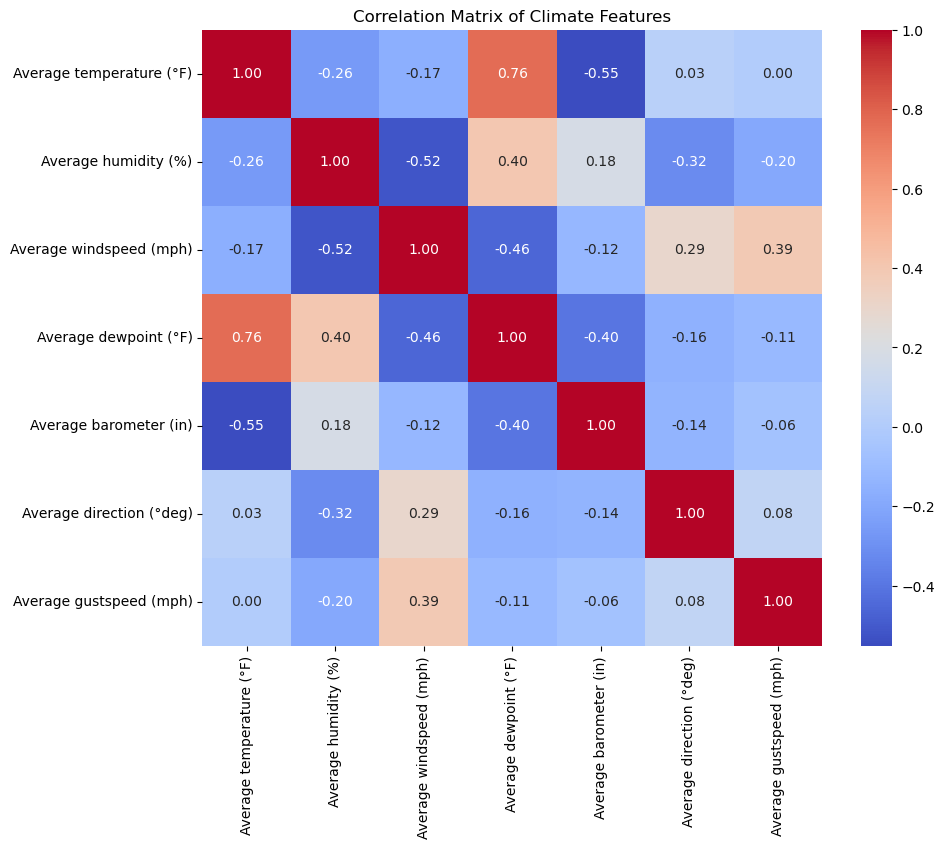

In [12]:
features_to_plot = ['Average temperature (°F)', 
                    'Average humidity (%)', 
                    'Average windspeed (mph)', 
                    'Average dewpoint (°F)', 
                    'Average barometer (in)', 
                    'Average direction (°deg)',
                    'Average gustspeed (mph)'
                   ]
plt.figure(figsize=(10, 8))
correlation_matrix = data[features_to_plot].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Climate Features')
plt.show()

Features we need to keep for our learning of average temperature will be :
- Average dewpoint(°F)
- Average barometer (in)
- Average humidity (%) 
- Average windspeed (mph)

The others isn't correlated enought or didn't have a strong seasonality for SARIMAX to be used as features for our prediction of the average temperature so we can drop it.

In [13]:
data = data.drop(columns=[ 'Average direction (°deg)',
                          'Average gustspeed (mph)'])

At this stage, the analysis will be extended by incorporating maximum, minimum, and difference-based features for the main meteorological variables (such as humidity, wind speed, and pressure). These derived features aim to capture the intra-day variability and amplitude of atmospheric conditions, which are not fully represented by average values alone. In particular, the difference between maximum and minimum values is expected to reflect the intensity of daily fluctuations and potential instability in weather patterns. This approach is motivated by the hypothesis that temperature dynamics may be influenced not only by absolute levels of meteorological variables, but also by their variability, especially during transitional seasons. By enriching the feature set with these statistics, the goal is to provide the model with more expressive information, potentially improving its ability to learn non-linear relationships and temporal dependencies before any feature importance or performance evaluation is conducted.

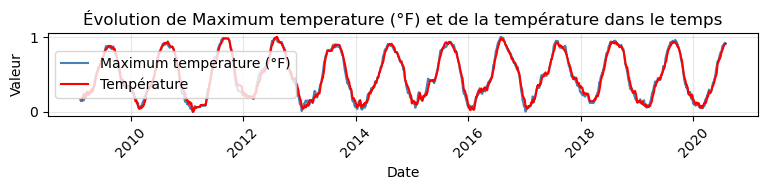

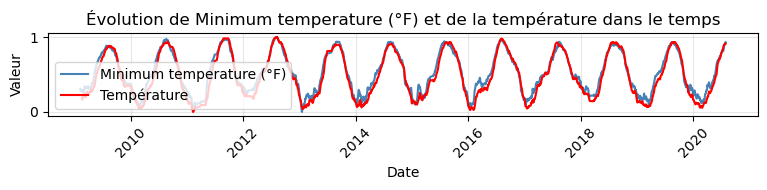

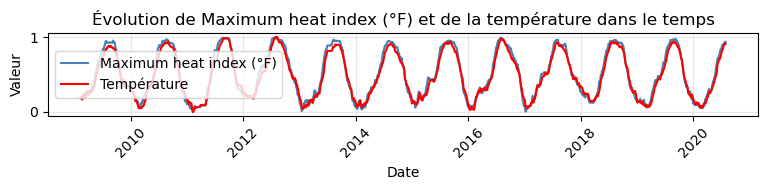

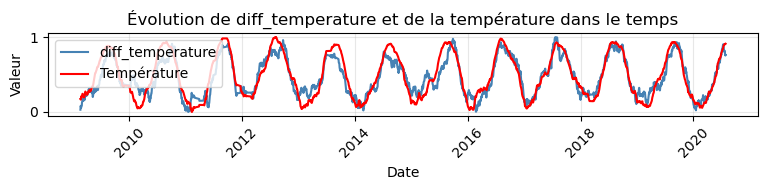

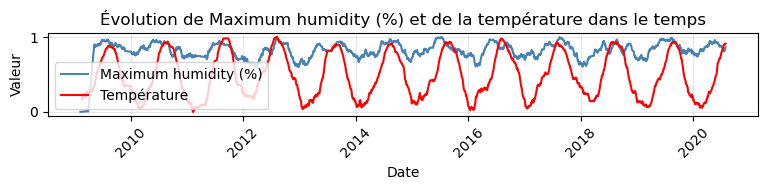

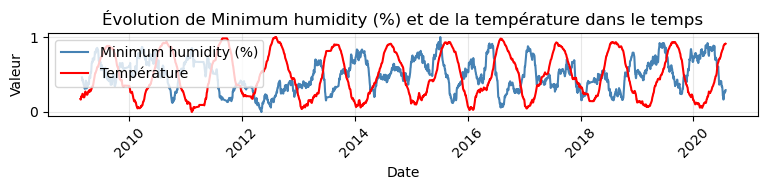

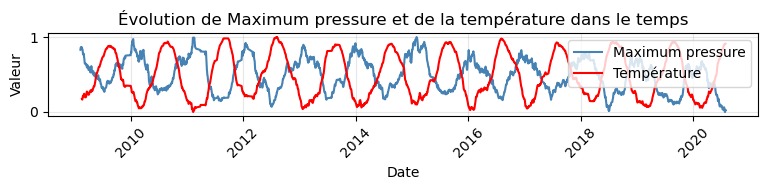

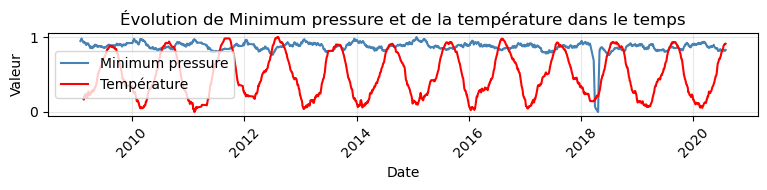

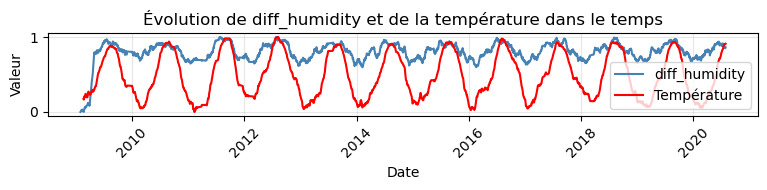

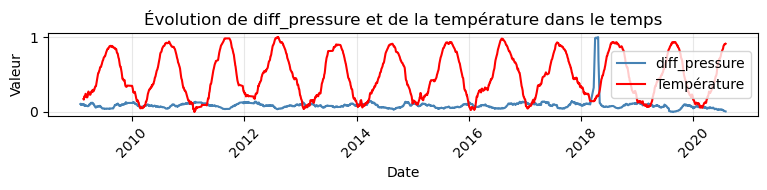

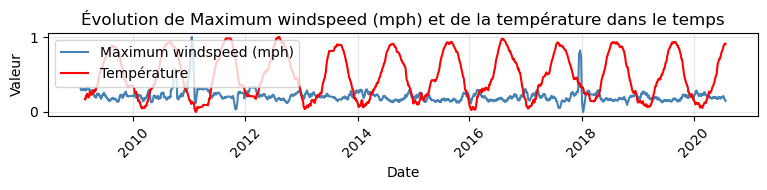

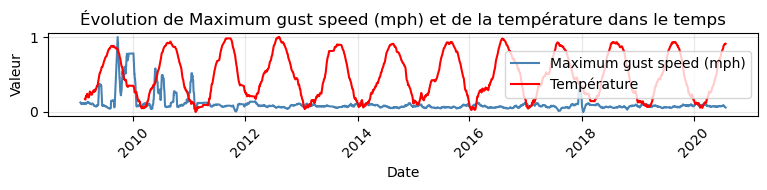

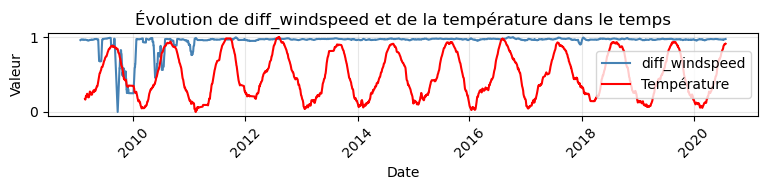

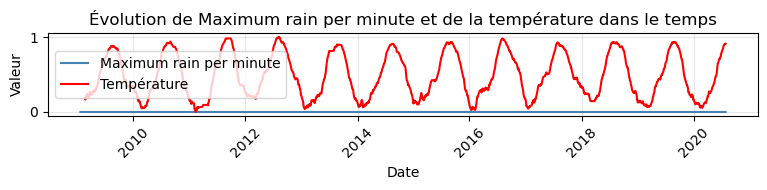

In [14]:
data['diff_temperature'] = data['Maximum temperature (°F)'] - data['Minimum temperature (°F)']
data['diff_humidity'] = data['Maximum humidity (%)'] - data['Minimum humidity (%)']
data['diff_pressure'] = data['Maximum pressure'] - data['Minimum pressure']
data['diff_windspeed'] = data['Maximum windspeed (mph)'] - data['Maximum gust speed (mph)']

features_to_plot = {
    # Temperature
    'Maximum temperature (°F)': 40,
    'Minimum temperature (°F)': 40,
    'Maximum heat index (°F)': 40,
    'diff_temperature': 50,

    # Humidity & Pressure
    'Maximum humidity (%)': 40,
    'Minimum humidity (%)': 60,
    'Maximum pressure': 40,
    'Minimum pressure': 30,
    'diff_humidity': 30,
    'diff_pressure': 30,

    # Wind
    'Maximum windspeed (mph)': 20,
    'Maximum gust speed (mph)': 20,
    'diff_windspeed': 20,

    # Rain
    'Maximum rain per minute': 20
}

# Let's use rolling and mean to take out the noise
data_smooth = data.copy()
data_smooth[target] = data_smooth[target].rolling(50).mean()
for feature, win in features_to_plot.items():
    data_smooth[feature] = data_smooth[feature].rolling(window=win).mean()
# Now we are going to normalize it for a better readability
scaler = MinMaxScaler()
scaled_cols = [target] + list(features_to_plot.keys())
scaled_df = data_smooth.copy()
scaled_df[scaled_cols] = scaler.fit_transform(data_smooth[scaled_cols])
# As not all features have the same measurement units, we will create separate plots for each feature
# We use the Date feature as x-axis for time series plots
for feature in features_to_plot.keys():
    plt.figure(figsize=(8, 2))
    plt.title(f"Évolution de {feature} et de la température dans le temps")
    
    # Courbe du feature
    sns.lineplot(data = scaled_df,x="Date", y=feature, label=feature, color='steelblue')
    
    # Courbe de la température
    sns.lineplot(data = scaled_df,x="Date", y=target, label='Température', color='red')
    
    plt.xlabel("Date")
    plt.ylabel("Valeur")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

Based on the visual inspection of the engineered features, it appears that not all derived variables carry the same level of information for temperature modeling. Features directly related to temperature, such as maximum temperature, minimum temperature, and maximum heat index, exhibit a strong seasonal alignment with the average temperature, suggesting a high degree of correlation. Similarly, difference-based features for temperature and humidity seem to capture meaningful variability and may provide complementary information about daily amplitude rather than absolute levels. In contrast, wind-related features (maximum wind speed, maximum gust speed, and wind speed differences) display high short-term variability and weak seasonal structure, indicating a limited relationship with temperature. Rain-related features show almost no visible correlation, as rainfall events are sparse and largely independent of temperature trends. 

However, visual similarity alone is not sufficient to draw definitive conclusions. Therefore, a correlation heatmap will be used to quantitatively verify these relationships and to identify redundant features that convey the same information. In particular, if maximum, minimum, and average temperature are found to be highly correlated, only the difference-based temperature feature (diff_temperature) will be retained in order to reduce redundancy while preserving information on variability.

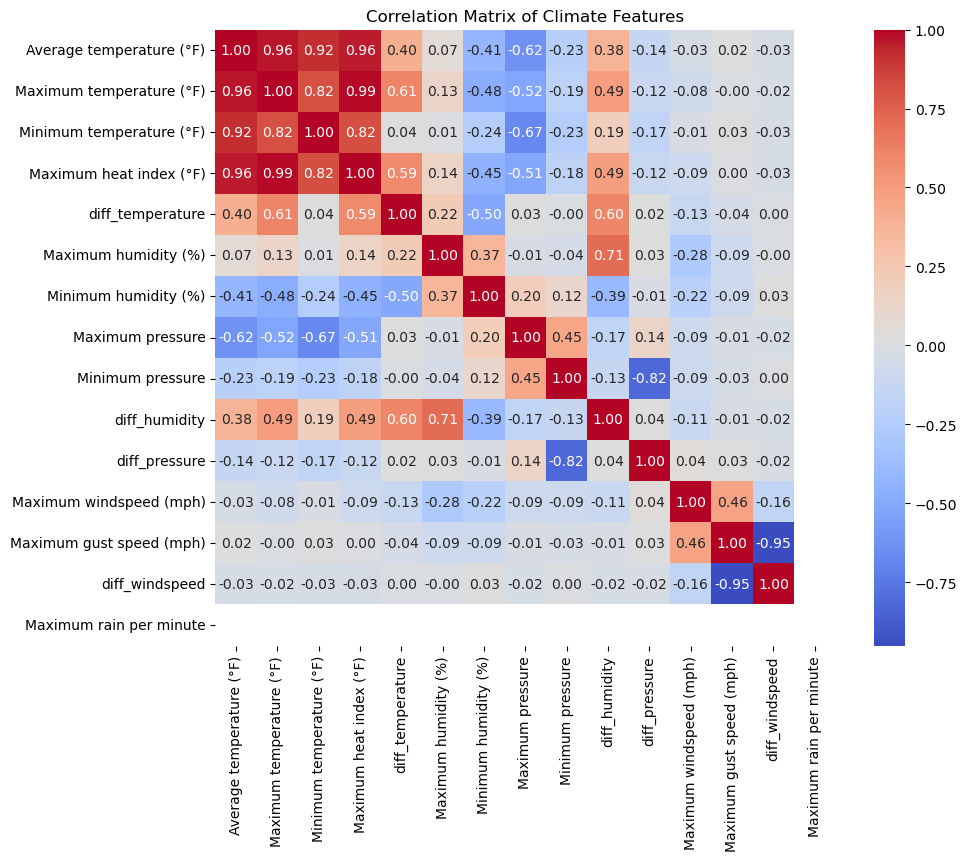

In [15]:
features_to_plot = [ 'Average temperature (°F)',
    'Maximum temperature (°F)',
    'Minimum temperature (°F)',
    'Maximum heat index (°F)',
    'diff_temperature',

    # Humidity & Pressure
    'Maximum humidity (%)',
    'Minimum humidity (%)',
    'Maximum pressure',
    'Minimum pressure',
    'diff_humidity',
    'diff_pressure',

    # Wind
    'Maximum windspeed (mph)',
    'Maximum gust speed (mph)',
    'diff_windspeed',

    # Rain
    'Maximum rain per minute'
                   ]
plt.figure(figsize=(10, 8))
correlation_matrix = data[features_to_plot].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Climate Features')
plt.show()

So we are going to drop all the features with a correlation between -0.4 and 0.4, and also if its more than 0.9 and less than -0.9 becauss it's probably just the same information of average.

Features we need to keep for our learning of average temperature will be :
- diff_humidity
- Maximum pressure
- Minimum humidity (%)
- diff_temperature

We keep diff_humidity and min humidity because they are not highly correlated (-0.39) so they give different information

In [16]:
data = data.drop(columns=['Maximum temperature (°F)',
                          'Minimum temperature (°F)',
                          'Maximum heat index (°F)',
                          'Maximum humidity (%)',
                          'Minimum pressure',
                          'diff_pressure',
                          'Maximum windspeed (mph)',
                          'Maximum gust speed (mph)',
                          'diff_windspeed',
                          'Maximum rain per minute'])

We now focus on evaluating the importance of date-based features. Temporal variables are expected to play a key role in temperature dynamics due to seasonality and long-term trends. 

To assess their relevance, we use a Spearman correlation matrix, which is well suited for this task as it captures monotonic and non-linear relationships. This is particularly important for temperature-related data, where seasonal patterns follow a cyclic structure rather than a strictly linear relationship. By analyzing the Spearman correlations between temperature and temporal features (such as day of year or seasonal encodings), we aim to identify which date-derived variables effectively encode seasonality and should be retained for modeling.

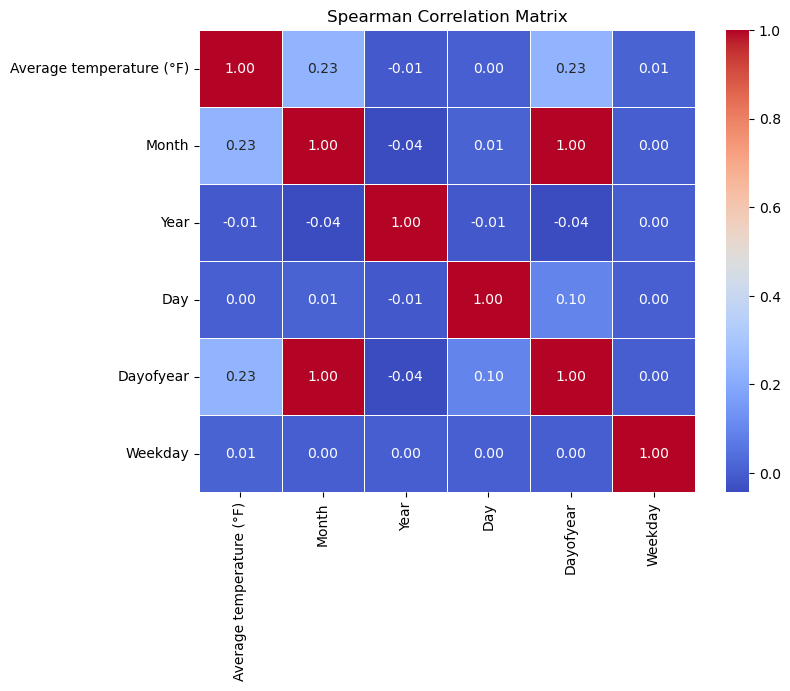

In [17]:
cols = ['Average temperature (°F)','Month', 'Year', 'Day', 'Dayofyear', 'Weekday']
corr_spearman = data[cols].corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation Matrix")
plt.show()

Without a strong correlation, we can see that only Month and Dayofyear are correlated with temperature. We also notice that Month and Dayofyear provide the same information, as they have a correlation score of 1. Therefore, we will continue the analysis only with Dayofyear to check whether it is worth keeping as a feature.

In [18]:
X = data[['Dayofyear']]
y = data['Average temperature (°F)']

mi = mutual_info_regression(X, y)
print(mi)

[0.67903563]


With a Mutual Information (MI) score greater than 0.5, the Dayofyear feature should unquestionably be retained. Mutual Information measures the amount of information shared between two variables, capturing both linear and non-linear dependencies. Unlike correlation coefficients, MI does not assume any specific functional relationship, making it particularly well suited for detecting seasonal effects. A high MI score indicates that knowing the day of the year significantly reduces uncertainty about the temperature. This confirms that Dayofyear is one of the strongest predictors of temperature, as it effectively encodes the annual seasonal cycle that dominates temperature behavior.

In [19]:
data = data.drop(columns=['Month', 'Year', 'Day', 'Weekday'])

The last features we don't studie are about rainfall

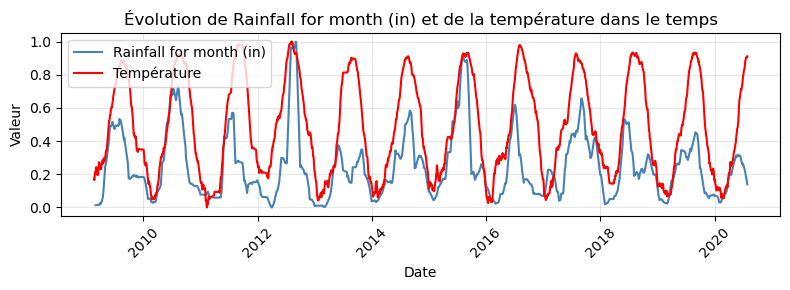

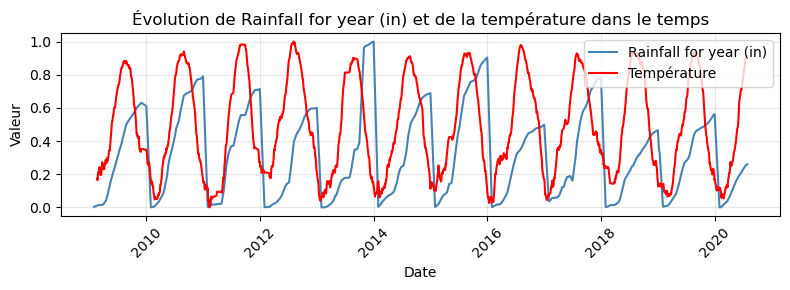

In [20]:
# Let's plot a few features to visualize their distributions and check for outliers
features_to_plot = {'Rainfall for month (in)': 60, 
                    'Rainfall for year (in)':30 

}
target = 'Average temperature (°F)'
# Let's use rolling and mean to take out the noise
data_smooth = data.copy()
data_smooth[target] = data_smooth[target].rolling(50).mean()
for feature, win in features_to_plot.items():
    data_smooth[feature] = data_smooth[feature].rolling(window=win).mean()
# Now we are going to normalize it for a better readability
scaler = MinMaxScaler()
scaled_cols = [target] + list(features_to_plot.keys())
scaled_df = data_smooth.copy()
scaled_df[scaled_cols] = scaler.fit_transform(data_smooth[scaled_cols])
# As not all features have the same measurement units, we will create separate plots for each feature
# We use the Date feature as x-axis for time series plots
for feature in features_to_plot.keys():
    plt.figure(figsize=(8, 3))
    plt.title(f"Évolution de {feature} et de la température dans le temps")
    
    # Courbe du feature
    sns.lineplot(data = scaled_df,x="Date", y=feature, label=feature, color='steelblue')
    
    # Courbe de la température
    sns.lineplot(data = scaled_df,x="Date", y=target, label='Température', color='red')
    
    plt.xlabel("Date")
    plt.ylabel("Valeur")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

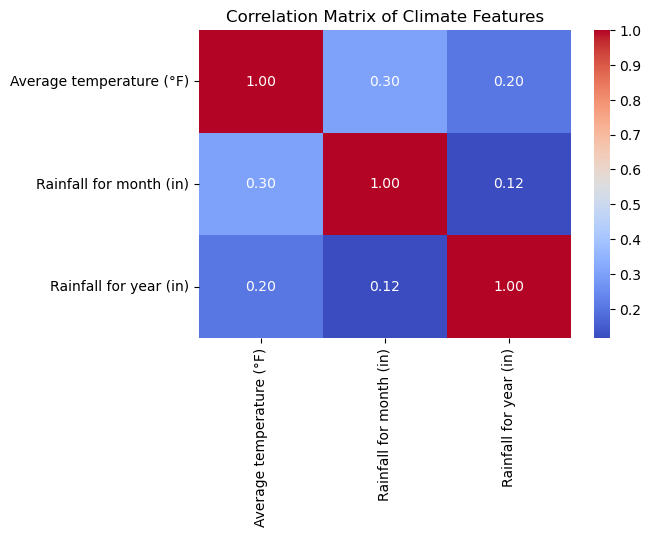

In [21]:
features_to_plot = [ 'Average temperature (°F)',
                    'Rainfall for month (in)', 
                    'Rainfall for year (in)'
                   ]
plt.figure(figsize=(6, 4))
correlation_matrix = data[features_to_plot].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Climate Features')
plt.show()

But the rainfall features are cumulative so let take other look and maybe create rainfall per day

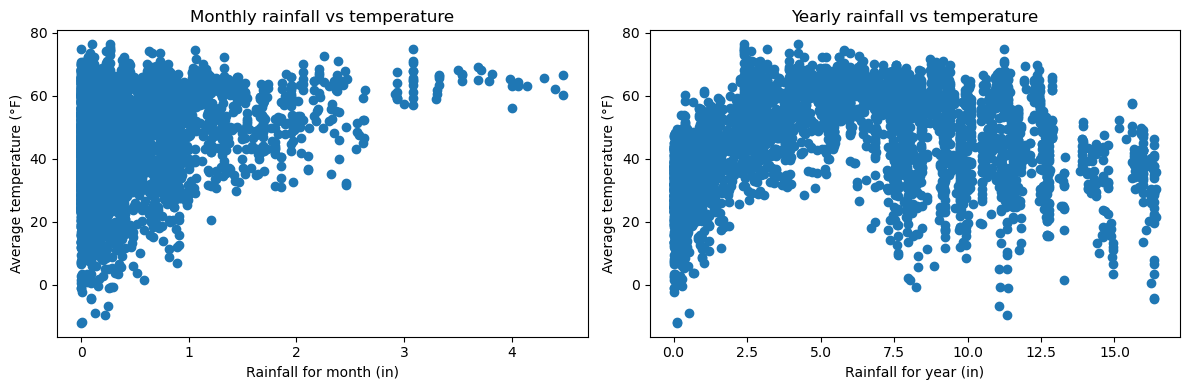

Rainfall for month (in) 0.1471954558702535
Rainfall for year (in) 0.37067106236260816


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(data['Rainfall for month (in)'], data['Average temperature (°F)'])
axes[0].set_xlabel('Rainfall for month (in)')
axes[0].set_ylabel('Average temperature (°F)')
axes[0].set_title('Monthly rainfall vs temperature')
axes[1].scatter(data['Rainfall for year (in)'], data['Average temperature (°F)'])
axes[1].set_xlabel('Rainfall for year (in)')
axes[1].set_ylabel('Average temperature (°F)')
axes[1].set_title('Yearly rainfall vs temperature')
plt.tight_layout()
plt.show()

X = data[['Rainfall for month (in)', 'Rainfall for year (in)']]
y = data['Average temperature (°F)']

mi = mutual_info_regression(X, y)
for feature, value in zip(X.columns, mi):
    print(feature, value)


Monthly and yearly rainfall are cumulative variables, so they cannot be used directly to predict daily average temperature because they create spurious time-based correlations. Since Dayofyear already captures the progression of the seasons, the yearly cumulative rainfall becomes redundant: its informational value mainly comes from time passing, not from rainfall itself. So we are going to create Rainfall for day (in) to be sure is useless

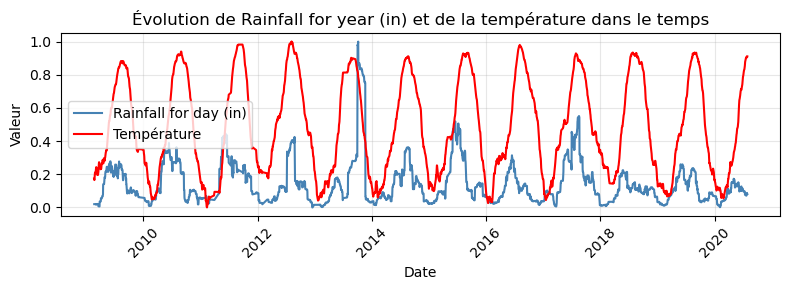

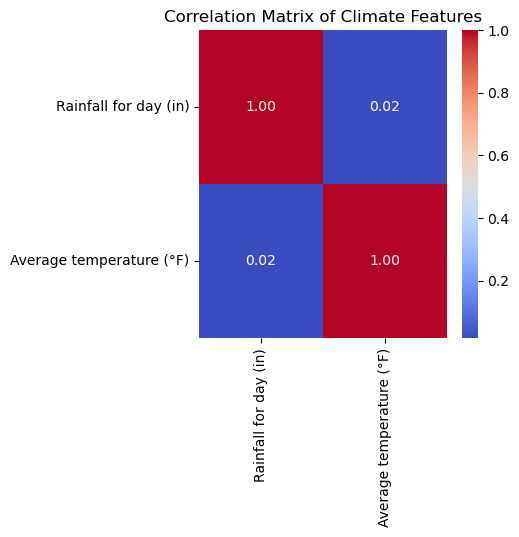

In [23]:
data['Rainfall for day (in)'] = data['Rainfall for year (in)'].diff()
# Correction: convert negative values (caused by the January 1st reset) to zero.
data.loc[data['Rainfall for day (in)'] < 0, 'Rainfall for day (in)'] = 0

data_smooth = data.copy()
data_smooth[['Rainfall for day (in)', target]] = (
    data_smooth[['Rainfall for day (in)', target]].rolling(50).mean()
)
# Now we are going to normalize it for a better readability
scaler = MinMaxScaler()
scaled_cols = [target] + ['Rainfall for day (in)']
scaled_df = data_smooth.copy()
scaled_df[scaled_cols] = scaler.fit_transform(data_smooth[scaled_cols])
plt.figure(figsize=(8, 3))
plt.title(f"Évolution de {feature} et de la température dans le temps")    
# Courbe du feature
sns.lineplot(data = scaled_df,x="Date", y='Rainfall for day (in)', label='Rainfall for day (in)', color='steelblue')  
# Courbe de la température
sns.lineplot(data = scaled_df,x="Date", y=target, label='Température', color='red')    
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

features_to_plot = ['Rainfall for day (in)',
                    target]
plt.figure(figsize=(4, 4))
correlation_matrix = data[features_to_plot].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Climate Features')
plt.show()

This is expected, as temperature follows a strong seasonal cycle while daily rainfall is highly irregular and non-seasonal

In [24]:
data = data.drop(columns=['Rainfall for month (in)',
                          'Rainfall for year (in)',
                          'Rainfall for day (in)'])

Now that the irrelevant features have been dropped, we need to check whether any of the remaining features carry the same information, to avoid redundancy in the model.

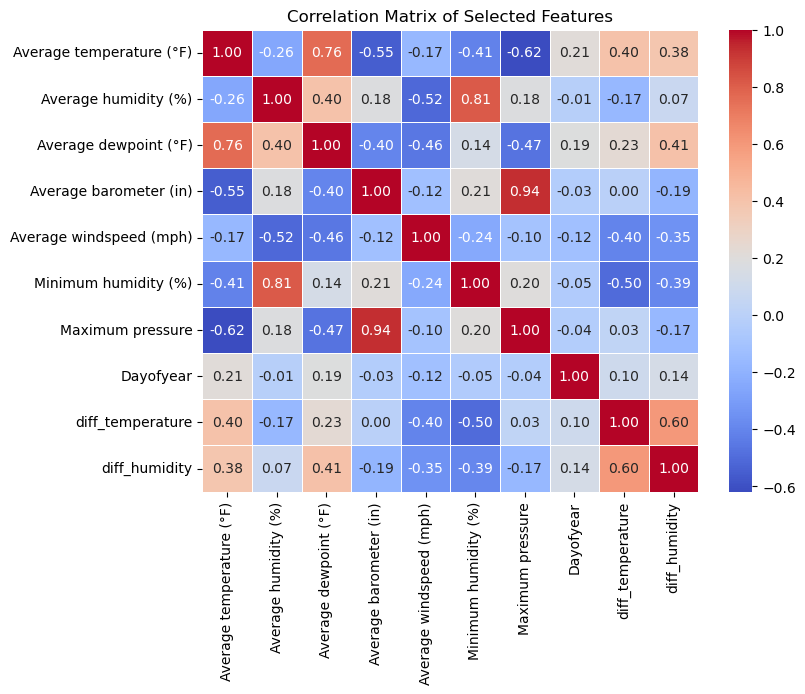

In [25]:
corr = data.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.show()

The correlation matrix shows that only Average barometer and Maximum pressure are redundant, with a correlation of 0.94 same for Minimum humidity and Average humidity. Therefore, we keep Average barometer and Average humidity. All other features show acceptable levels of correlation and provide complementary information.

In [26]:
print(data['Dayofyear'])

Date
2009-01-01      1
2009-01-02      2
2009-01-03      3
2009-01-04      4
2009-01-05      5
             ... 
2020-07-24    206
2020-07-25    207
2020-07-26    208
2020-07-27    209
2020-07-28    210
Name: Dayofyear, Length: 3902, dtype: int32


In [27]:
df = pd.read_csv("climate_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['diff_temperature'] = df['Maximum temperature (°F)'] - df['Minimum temperature (°F)']
df['diff_humidity'] = df['Maximum humidity (%)'] - df['Minimum humidity (%)']

data = df[['Average humidity (%)', 'Average windspeed (mph)', 'Average temperature (°F)', 'Average barometer (in)', 'Average dewpoint (°F)',  'diff_temperature', 'diff_humidity', 'Date1']]

In [28]:
data = data.asfreq('D')
data.isna().sum()

Average humidity (%)        325
Average windspeed (mph)     325
Average temperature (°F)    325
Average barometer (in)      325
Average dewpoint (°F)       325
diff_temperature            325
diff_humidity               325
Date1                       325
dtype: int64

There are in the dataset, missing dates. Some days do not appear so we need to create new lines and fill the lines with new values. We can use the fillna method from pandas to do so.

In [29]:
data = data.fillna(method='ffill')
data.isna().sum()
data['Dayofyear'] = data.index.dayofyear

C:\Users\paula\AppData\Local\Temp\ipykernel_33280\2495147597.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [30]:
data = data.drop(columns=['Date1'])

In [31]:
data.head()


,Average humidity (%),Average windspeed (mph),Average temperature (°F),Average barometer (in),Average dewpoint (°F),diff_temperature,diff_humidity,Dayofyear
Date,,,,,,,,
2009-01-01,35.0,26.4,37.8,29.7,12.7,6.0,-23.0,1
2009-01-02,32.0,12.8,43.2,29.5,14.7,15.0,-12.0,2
2009-01-03,60.0,8.3,25.7,29.7,12.7,35.0,-27.0,3
2009-01-04,67.0,2.9,9.3,30.4,0.1,19.0,-28.0,4
2009-01-05,30.0,16.7,23.5,29.9,-5.3,15.0,-8.0,5


So features we will use are :
- Average dewpoint(°F)
- Average humidity (%)
- Average windspeed (mph)
- Average barometer (in)
- Dayofyear
- diff_temperature
- diff_humidity

In [32]:
data['day_sin'] = np.sin(2 * np.pi * data['Dayofyear'] / 365)
data['day_cos'] = np.cos(2 * np.pi * data['Dayofyear'] / 365)
data = data.drop(columns=['Dayofyear'])

In [33]:
X = data[['day_sin', 'day_cos']]
y = data['Average temperature (°F)']

mi = mutual_info_regression(X, y)
for feature, value in zip(X.columns, mi):
    print(feature, value)

day_sin 0.27689053788376317
day_cos 0.5365927618445561


The cyclic encoding of Dayofyear improved the representation of seasonal patterns: day_cos provides strong information (MI = 0.53) and day_sin adds complementary variability (MI = 0.27). Together, they capture more information than the raw Dayofyear feature.

We are looking to predict and compute the frost point
============
Using the temperature and dewpoint

Let's scaled features to give a better lisibility for models with the isolation of the target because noralize it isn't necessary

In [34]:
data_scaled = data.copy()

target = data_scaled['Average temperature (°F)']

cols_to_scale = data_scaled.columns.drop('Average temperature (°F)')

scaler = StandardScaler()
data_scaled[cols_to_scale] = scaler.fit_transform(data_scaled[cols_to_scale])

data_scaled['Average temperature (°F)'] = target

print("Scaling done, index preserved!")
data_scaled.head()



Scaling done, index preserved!


,Average humidity (%),Average windspeed (mph),Average temperature (°F),Average barometer (in),Average dewpoint (°F),diff_temperature,diff_humidity,day_sin,day_cos
Date,,,,,,,,,
2009-01-01,-0.791761,5.015002,37.8,-0.727222,-0.701778,-1.987259,-3.441747,-0.012370,1.418315
2009-01-02,-0.964906,1.687969,43.2,-1.534249,-0.565985,-1.100512,-2.907472,0.012056,1.417688
2009-01-03,0.651112,0.587112,25.7,-0.727222,-0.701778,0.870037,-3.636029,0.036467,1.416644
2009-01-04,1.055117,-0.733916,9.3,2.097374,-1.557274,-0.706402,-3.684599,0.060857,1.415182
2009-01-05,-1.080336,2.642044,23.5,0.079805,-1.923914,-1.100512,-2.713190,0.085218,1.413304


In [35]:
def evaluate(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"\n {name}")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")
    return mae, rmse, r2

This will be very useful for evaluate the different models

In [38]:
target = "Average temperature (°F)"
features = ['Average humidity (%)', 
            'Average windspeed (mph)',
            'Average barometer (in)',
            'Average dewpoint (°F)',
            'diff_temperature',
            'diff_humidity',
            'day_sin',
            'day_cos'
            ]

Let's split the data in train and test 

In [39]:
df_scaled = pd.DataFrame(data_scaled)
X = df_scaled[features]
y = df_scaled[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

split = int(len(data) * 0.8)

X_train_s = X.iloc[:split]
y_train_s = y.iloc[:split]

X_test_s  = X.iloc[split:]
y_test_s  = y.iloc[split:]

Now you are going to train different model to choose your process

In [40]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

xg = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)

xg.fit(X_train, y_train)
xg_pred = xg.predict(X_test)

lg = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.03
)

lg.fit(X_train, y_train)
lg_pred = lg.predict(X_test)

svr = SVR(C=10, epsilon=0.1, kernel="rbf")
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

X_train_lstm = np.array(X_train).reshape((-1, 1, X_train.shape[1]))
X_test_lstm  = np.array(X_test).reshape((-1, 1, X_test.shape[1]))

model = Sequential([
    LSTM(64, input_shape=(1, X_train.shape[1])),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)

lstm_pred = model.predict(X_test_lstm).flatten()

c:\Users\paula\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\paula\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\paula\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\paula\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\paula\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(e

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 3381, number of used features: 8
[LightGBM] [Info] Start training from score 44.367022


c:\Users\paula\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


We are going to evaluate it to see what we will keep

In [41]:
results = {}
results["SVR"] = evaluate("SVR", y_test, svr_pred)
results["LightGBM"] = evaluate("LightGBM", y_test, lg_pred)
results["XGBoost"] = evaluate("XGBoost", y_test, xg_pred)
results["RandomForest"] = evaluate("RandomForest", y_test, rf_pred)
results["LSTM"] = evaluate("LSTM", y_test, lstm_pred)


 SVR
MAE  : 0.5758
RMSE : 0.9123
R²   : 0.9965

 LightGBM
MAE  : 0.8309
RMSE : 1.1430
R²   : 0.9944

 XGBoost
MAE  : 0.9854
RMSE : 1.3552
R²   : 0.9922

 RandomForest
MAE  : 1.0778
RMSE : 1.5805
R²   : 0.9894

 LSTM
MAE  : 1.2080
RMSE : 1.5955
R²   : 0.9891


As we can see best models are SVR, LightGBM and XGBoost so to have the best performance possible we are going to use GridSearchCV for the three and see who is better but also use a mean of the three result because it could be the best solution.

In [42]:
params = {
    "C": [1, 5, 10, 30, 50, 100],
    "epsilon": [0.01, 0.05, 0.1, 0.2],
    "gamma": ["scale", "auto", 0.1, 0.01, 0.001],
    "kernel": ["rbf"]   # kernel RBF = le meilleur pour météo
}

svr = SVR()

grid_svr = GridSearchCV(
    estimator=svr,
    param_grid=params,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_svr.fit(X_train, y_train)
svr_best = grid_svr.best_estimator_
svr_best_pred = svr_best.predict(X_test)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [43]:
lgbm = lgb.LGBMRegressor()

param_grid_lg = {
    'num_leaves': [20, 31, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400, 600],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8, 1.0],
}

grid_lg = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid_lg,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_lg.fit(X_train, y_train)
lg_best = grid_lg.best_estimator_
lg_best_pred = lg_best.predict(X_test)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 3381, number of used features: 8
[LightGBM] [Info] Start training from score 44.367022


In [44]:
xg_model = xgb.XGBRegressor(tree_method="hist", enable_categorical=False)

param_grid_xg = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.03, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_xg = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid_xg,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_xg.fit(X_train, y_train)

xg_best = grid_xg.best_estimator_
xg_best_pred = xg_best.predict(X_test)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [45]:
def evaluate_model_overfitting(model, X_train, y_train, X_test, y_test):
    # ---- TRAIN PREDICTION ----
    train_pred = model.predict(X_train)
    test_pred  = model.predict(X_test)

    # ---- METRICS ----
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae  = mean_absolute_error(y_test, test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse  = np.sqrt(mean_squared_error(y_test, test_pred))

    print("\n===== OVERFITTING TEST =====")
    print(f"Train MAE : {train_mae:.4f}")
    print(f"Test  MAE : {test_mae:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test  RMSE: {test_rmse:.4f}")

    # ---- INTERPRETATION ----
    print("\n===== INTERPRETATION =====")
    if test_rmse > train_rmse * 1.5:
        print("overfitting.")
    elif test_rmse > train_rmse * 1.2:
        print("little overfitting.")
    else:
        print("ne overfetting.")

    return {
        "train_mae": train_mae,
        "test_mae": test_mae,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse
    }
evaluate_model_overfitting(svr_best, X_train, y_train, X_test, y_test)
evaluate_model_overfitting(lg_best, X_train, y_train, X_test, y_test)
evaluate_model_overfitting(xg_best, X_train, y_train, X_test, y_test)



===== OVERFITTING TEST =====
Train MAE : 0.3269
Test  MAE : 0.4730
Train RMSE: 0.5519
Test  RMSE: 0.6999

===== INTERPRETATION =====
little overfitting.

===== OVERFITTING TEST =====
Train MAE : 0.3608
Test  MAE : 0.8362
Train RMSE: 0.4761
Test  RMSE: 1.1352

===== INTERPRETATION =====
overfitting.

===== OVERFITTING TEST =====
Train MAE : 0.3855
Test  MAE : 0.8233
Train RMSE: 0.5069
Test  RMSE: 1.1285

===== INTERPRETATION =====
overfitting.


{'train_mae': 0.3855069821013462,
 'test_mae': 0.8232881249406376,
 'train_rmse': 0.506861038468926,
 'test_rmse': 1.1285366289669936}

In [46]:
together_pred = (svr_best_pred + lg_best_pred + xg_best_pred) / 3
together2 = (svr_best_pred  + xg_best_pred) / 2
results["SVR"] = evaluate("SVR optimised", y_test, svr_pred)
results["LightGBM"] = evaluate("LightGBM optimised", y_test, lg_best_pred)
results["XGBoost"] = evaluate("XGBoost optimised", y_test, xg_best_pred)
results["Together"] = evaluate("Together (SVR + LGBM + XGB)", y_test, together_pred)
results["Together2"] = evaluate("Together (SVR + XGB)", y_test, together2)


 SVR optimised
MAE  : 0.5758
RMSE : 0.9123
R²   : 0.9965

 LightGBM optimised
MAE  : 0.8362
RMSE : 1.1352
R²   : 0.9945

 XGBoost optimised
MAE  : 0.8233
RMSE : 1.1285
R²   : 0.9946

 Together (SVR + LGBM + XGB)
MAE  : 0.6309
RMSE : 0.8716
R²   : 0.9968

 Together (SVR + XGB)
MAE  : 0.5743
RMSE : 0.8032
R²   : 0.9973


Although SVR and XGBoost achieve the best raw performance scores, they both suffer from significant overfitting, as their training errors are much lower than their test errors. This indicates that these models tend to memorize the training data rather than generalize well to unseen observations. In contrast, most of the tested models exhibit overfitting, with the notable exception of SARIMAX. Thanks to its explicit modeling of temporal dependencies and seasonality, SARIMAX provides a more balanced bias–variance tradeoff. As a result, despite slightly lower performance metrics, SARIMAX is the most reliable choice, as it captures seasonal temperature patterns while maintaining strong generalization performance.

We have a probleme, we don't have the features to predict the next years. We can have the next week with regression but for next year we need an other model and we will use SARIMAX. We use y_train_s and X_train_s because to be well performante Sarimax need to be continue and value that didn't scaled.

In [47]:
features = ['Average humidity (%)', 
            'Average windspeed (mph)',
            'Average barometer (in)',
            'Average dewpoint (°F)',
            'diff_temperature',
            'diff_humidity',
            'day_sin',
            'day_cos'
            ]
data = pd.DataFrame(data)
X_s = data[features]
y_s = data[target]

split = int(len(data) * 0.8)

X_train_s = X_s.iloc[:split]
y_train_s = y_s.iloc[:split]

X_test_s  = X_s.iloc[split:]
y_test_s  = y_s.iloc[split:]

model = SARIMAX( y_train_s,X_train_s) #Build the SARIMAX model
SariModel = model.fit(disp = 1) #Fit the SARIMAx model

Sari_pred_test = SariModel.predict(
    start=y_test_s.index[0],
    end=y_test_s.index[-1],
    exog=X_test_s
)

evaluate("SARIMAX ", y_test_s, Sari_pred_test)

c:\Users\paula\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 SARIMAX 
MAE  : 1.8207
RMSE : 2.5117
R²   : 0.9749


(1.820742846851684, 2.5116651377779706, 0.9748754866584257)

In [48]:
def evaluate_sarimax_overfitting(model, y_train, X_train, y_test, X_test):

    pred_train = model.predict(
        start=y_train.index[0],
        end=y_train.index[-1],
        exog=X_train
    )

    pred_test = model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test
    )

    train_rmse = np.sqrt(mean_squared_error(y_train, pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test, pred_test))

    train_mae = mean_absolute_error(y_train, pred_train)
    test_mae  = mean_absolute_error(y_test, pred_test)

    print("\n===== OVERFITTING TEST =====")
    print(f"Train RMSE : {train_rmse:.4f}")
    print(f"Test  RMSE : {test_rmse:.4f}")
    print(f"Train MAE  : {train_mae:.4f}")
    print(f"Test  MAE  : {test_mae:.4f}")

    if test_rmse > train_rmse * 1.5:
        print("overfitting.")
    elif test_rmse > train_rmse * 1.2:
        print("little overfitting.")
    else:
        print("No overfitting.")

evaluate_sarimax_overfitting(
    SariModel,
    y_train_s, X_train_s,
    y_test_s,  X_test_s
)


===== OVERFITTING TEST =====
Train RMSE : 2.1406
Test  RMSE : 2.5117
Train MAE  : 1.6011
Test  MAE  : 1.8207
No overfitting.


The overfitting test for the SARIMAX model shows consistent performance between the training and test sets. The training RMSE (2.14) and test RMSE (2.51) are close, indicating that the model generalizes well to unseen data. Similarly, the training MAE (1.60) and test MAE (1.82) remain at comparable levels. The absence of a large performance gap between training and testing errors suggests that the model is not overfitting. This indicates that the selected features and temporal structure allow the SARIMAX model to capture the underlying temperature dynamics without memorizing the training data.

Text(0, 0.5, 'Temperature (F)')

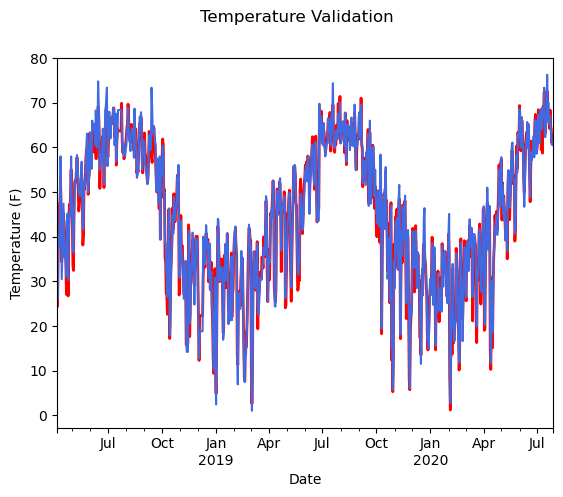

In [49]:
#Forecast for validation data
ax = Sari_pred_test.plot(subplots = True, color = "red", linewidth = 2, title = "Temperature Validation") #Plot the forecasted data
y_test_s.plot(ax = ax, subplots = True, color = "royalblue") #Plot the actual dewpoint
plt.ylabel("Temperature (F)")

In [50]:
# ============================
# 1. Générer les dates futures
# ============================
n_future = 365  # 1 an
last_date = data.index[-1]

future_index = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=n_future,
    freq="D"
)

# ============================
# 2. Construire X_future
# ============================
features = [
    'Average humidity (%)',
    'Average windspeed (mph)',
    'Average barometer (in)',
    'Average dewpoint (°F)',
    'diff_temperature',
    'diff_humidity',
    'day_sin',
    'day_cos'
]

# Seasonal naive pour les variables météo (on copie l'année précédente)
X_future = data[features].iloc[-365:].copy()
X_future.index = future_index

doy = future_index.dayofyear
X_future["day_sin"] = np.sin(2 * np.pi * doy / 365)
X_future["day_cos"] = np.cos(2 * np.pi * doy / 365)

X_future = X_future[features]


# 2. Concaténer exogènes train + test + futur
X_full = pd.concat([X_test_s, X_future], axis=0)

# 3. Prédiction sur la période future uniquement
forecast_future = SariModel.predict(
    start=X_future.index[0],     # première date future
    end=X_future.index[-1],      # dernière date future
    exog=X_full                  # exogènes complets : train + test + futur
)

print(forecast_future)


2020-07-29    66.543599
2020-07-30    71.438280
2020-07-31    61.052086
2020-08-01    61.471561
2020-08-02    64.652488
                ...    
2021-07-24    64.732835
2021-07-25    63.982092
2021-07-26    61.009062
2021-07-27    62.589643
2021-07-28    61.604664
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


Text(0, 0.5, 'Temperature (F)')

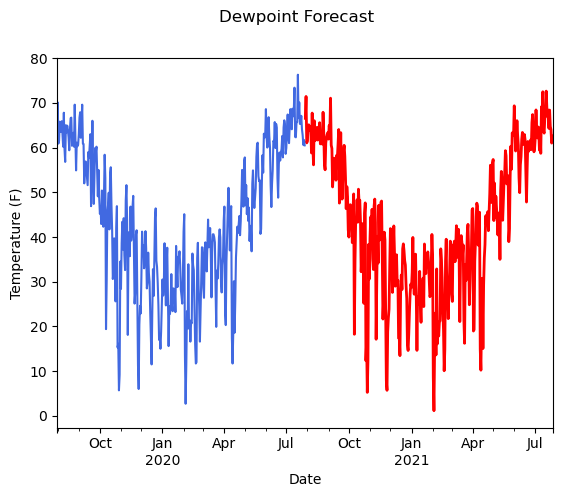

In [51]:
shortTemp = data['Average temperature (°F)'][len(data['Average temperature (°F)'])-365:]
ax = forecast_future.plot(subplots = True, color = "red", linewidth = 2, title = "Dewpoint Forecast") #Plot the dew forecast
shortTemp.plot(ax = ax, subplots = True, color = "royalblue") #Plot the shortened dew dataframe
plt.ylabel("Temperature (F)") 